In [80]:
import tensorflow_hub as hub
import tensorflow as tf
import cv2
import base64
import numpy as np
from urllib.request import Request, urlopen
import matplotlib.pyplot as plt
import time
from ipywidgets import FileUpload
import ipywidgets as widgets
from IPython.display import display, HTML
from google.colab import output as colab_output

np.random.seed(42)
tf.random.set_seed(42)

In [81]:
# Load SavedModel from TensorFlow Hub (Now Kaggle):
model = hub.KerasLayer("https://www.kaggle.com/models/vaishaknair456/u2-net-portrait-background-remover/tensorFlow2/40_saved_model/1")

In [82]:
def get_image_from_url(url, read_flag=cv2.IMREAD_COLOR):
    req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})
    resp = urlopen(req)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, read_flag)
    return image

In [83]:
def process_image(image):
    # Input image should be of height x width: 512 x 512 with 3 color channels:
    INPUT_IMG_HEIGHT = 512
    INPUT_IMG_WIDTH = 512
    INPUT_CHANNEL_COUNT = 3

    #image width and height
    h, w, channel_count = image.shape

    # Preprocess input image:
    if channel_count > INPUT_CHANNEL_COUNT:  # png images will have an alpha channel. Remove it:
        image = image[..., :INPUT_CHANNEL_COUNT]

    x = cv2.resize(image, (INPUT_IMG_WIDTH, INPUT_IMG_HEIGHT))  # Resize input image to 512 x 512 x 3
    x = x / 255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=0)

    # Generate the pixel-wise probability mask:
    probability = model(x)[0].numpy()
    probability = cv2.resize(probability, dsize=(w, h))  # Resize the probability mask from (512, 512, 1) to (h, w)
    probability = np.expand_dims(probability, axis=-1)  # Reshape the probability mask from (h, w) to (h, w, 1)

    alpha_image = np.insert(image, 3, 255.0, axis=2)  # Add an opaque alpha channel to the input image

    PROBABILITY_THRESHOLD = 0.7  # Pixels with probability values less than or equal to the threshold belong to the background class.

    # Apply the probability mask by making pixels with probability value <= PROBABILITY_THRESHOLD transparent in the output image:
    masked_image = np.where(probability > PROBABILITY_THRESHOLD, alpha_image, 0.0)

    return masked_image.astype(np.uint8)

# **Image Url** 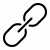

In [90]:
# List of URLs to process
urls = [
      "https://w0.peakpx.com/wallpaper/287/473/HD-wallpaper-captain-america-mqvel.jpg",
    "https://e1.pxfuel.com/desktop-wallpaper/160/565/desktop-wallpaper-hinata-hyuga-aesthetic-hinata-thumbnail.jpg",
    "https://e0.pxfuel.com/wallpapers/881/1007/desktop-wallpaper-nami-anime-one-piece-manga-thumbnail.jpg",
    # "https://wallpapers.com/images/hd/one-piece-anime-nami-nico-kj8y4ot4zwwrt30c.jpg",
]

Processing time: 8.96 seconds


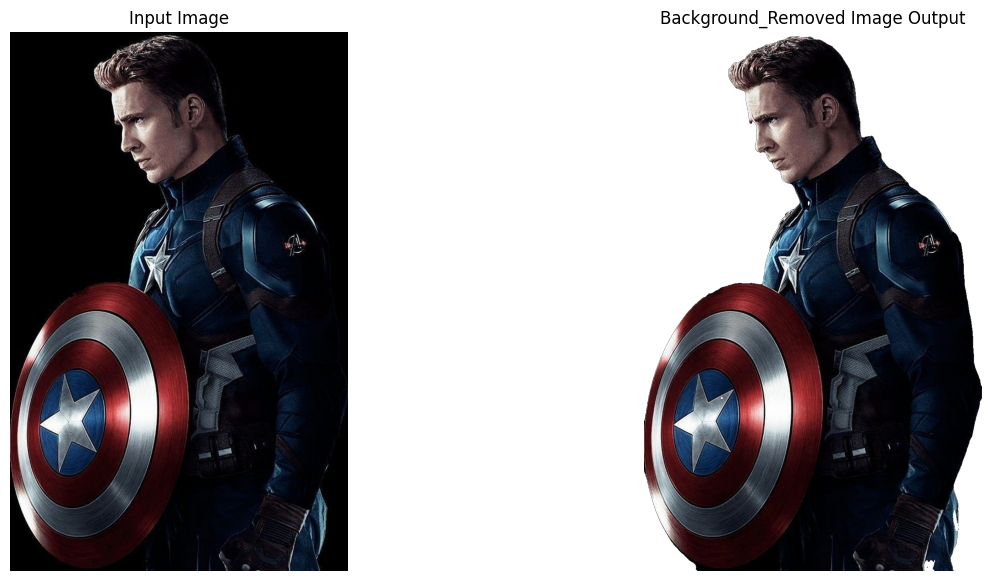

File processed successfully!
Processing time: 5.39 seconds


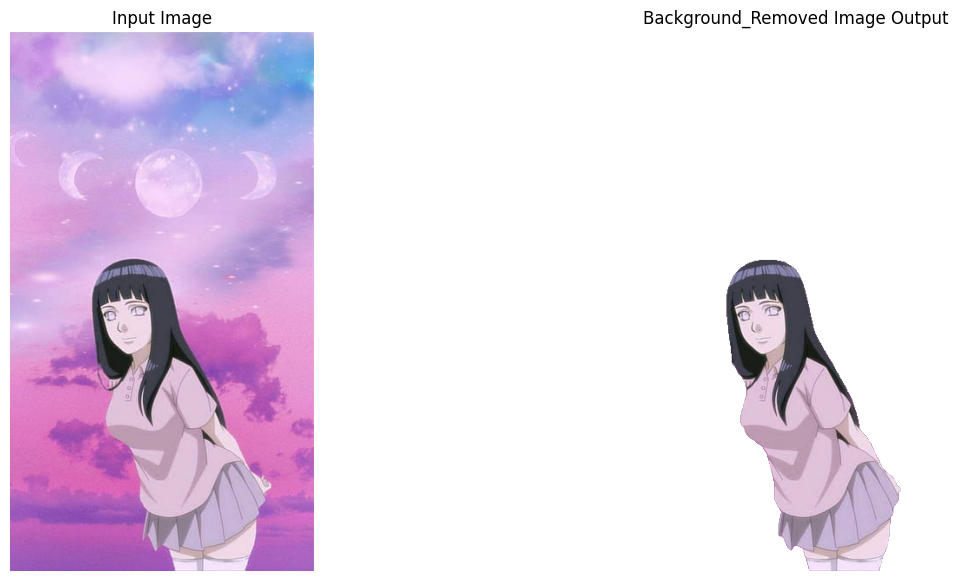

File processed successfully!
Processing time: 6.74 seconds


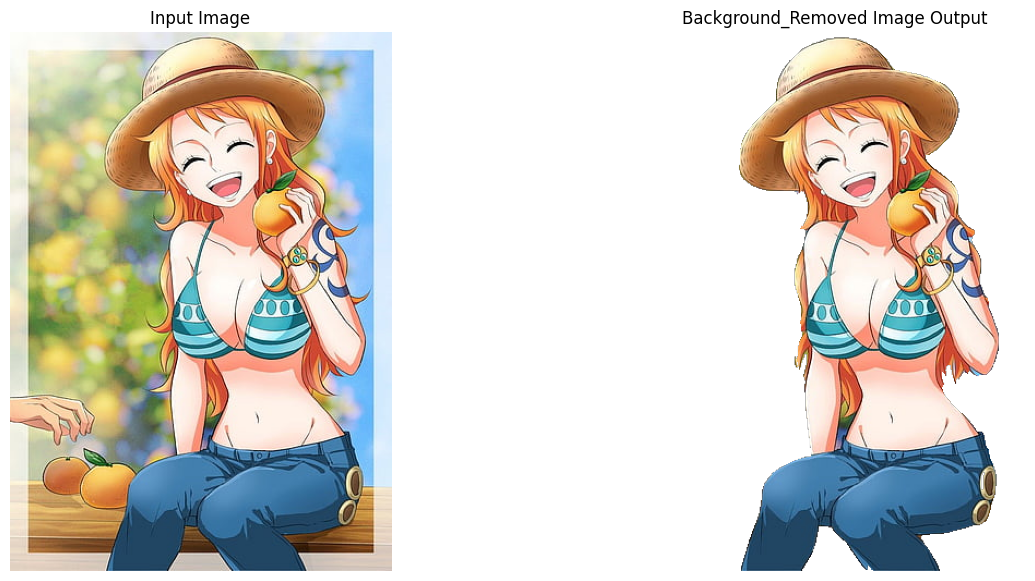

File processed successfully!


In [91]:
# Process each image and save/display results
for i, url in enumerate(urls):
    # Fetch and process the image
    image = get_image_from_url(url)
    start_time = time.time()
    # Process the image
    masked_image = process_image(image)
    # End timing the image processing
    end_time = time.time()
    processing_time = end_time - start_time
    # Display processing time
    print(f"Processing time: {processing_time:.2f} seconds")
    # Save the output
    output_filename = f"./output_{i+1}.png"
    cv2.imwrite(output_filename, masked_image)

    # Display input and output images using matplotlib
    plt.figure(figsize=(15, 7))

    # Display input image
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for displaying with matplotlib
    plt.axis('off')
    plt.title('Input Image')

    # Display output image
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGRA2RGBA))  # Convert BGRA to RGBA
    plt.axis('off')
    plt.title('Background_Removed Image Output')

    plt.show()
    print("File processed successfully!")


# **Uploding Image**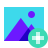

Processing time: 5.49 seconds


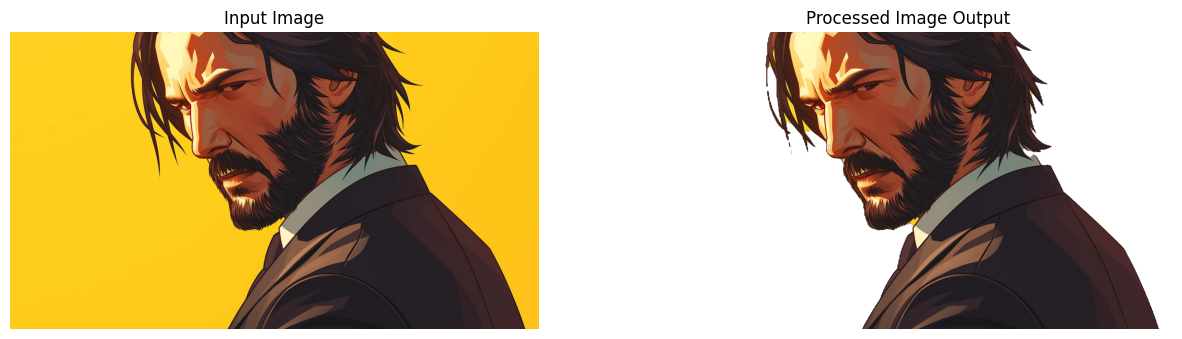

File processed successfully!
Processing time: 6.78 seconds


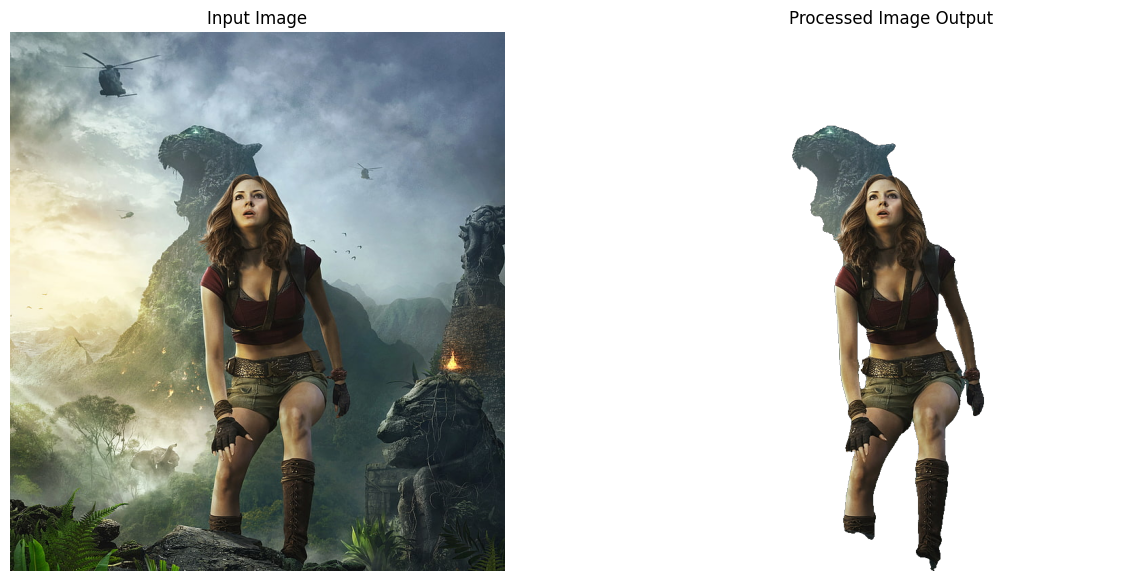

File processed successfully!


In [86]:
def handle_upload(change):
    for name, file in upload_widget.value.items():
        # Read the uploaded file
        image = np.asarray(bytearray(file['content']), dtype="uint8")
        image = cv2.imdecode(image, cv2.IMREAD_COLOR)

        start_time = time.time()

            # Process the image
        masked_image = process_image(image)

            # End timing the image processing
        end_time = time.time()
        processing_time = end_time - start_time
            # Display processing time
        print(f"Processing time: {processing_time:.2f} seconds")

        # Display input and output images using matplotlib
        plt.figure(figsize=(15, 7))

        # Display input image
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for displaying with matplotlib
        plt.axis('off')
        plt.title('Input Image')

        # Display output image
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGRA2RGBA))  # Convert BGRA to RGBA
        plt.axis('off')
        plt.title('Processed Image Output')

        plt.show()
        print("File processed successfully!")

# Create a file upload widget
upload_widget = widgets.FileUpload()

# Attach the handle_upload function to the upload widget
upload_widget.observe(handle_upload, names='value')

# Create a box layout for better styling
box_layout = widgets.Layout(display='flex',
                            flex_flow='column',
                            align_items='center',
                            border='solid 2px lightblue',
                            padding='10px',
                            width='50%')

# Create a label for instructions
label = widgets.Label("Please upload your file:")

# Create a vertical box container
vbox = widgets.VBox([label, upload_widget], layout=box_layout)

# Display the container
display(vbox)

# Optionally, add some custom CSS styling
style = """
<style>
    .widget-upload {
          color: white !important;
        background-color: #28a745 !important;
        font-size: 16px !important;
    }
</style>
"""
display(HTML(style))



# ***Drag and Drop the image***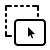

In [89]:
status_label = widgets.Label("Drag and drop an image file here")
output_widget = widgets.Output()
def handle_file(file):
    with output_widget:
        output_widget.clear_output()
        # Read the uploaded image
        img_bytes = file.split(",")[1]
        img_array = np.frombuffer(bytearray(base64.b64decode(img_bytes)), dtype=np.uint8)
        image = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
        start_time = time.time()
        # Process the image to remove the background
        processed_image = process_image(image)
        # End timing the image processing
        end_time = time.time()
        processing_time = end_time - start_time
            # Display processing time
        print(f"Processing time: {processing_time:.2f} seconds")

        # Display input and output images
        fig, axs = plt.subplots(1, 2, figsize=(15, 7))

        # Display input image
        axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axs[0].axis('off')
        axs[0].set_title('Input Image')

        # Display processed (background removed) image
        axs[1].imshow(cv2.cvtColor(processed_image, cv2.COLOR_BGRA2RGBA))
        axs[1].axis('off')
        axs[1].set_title('Processed Image Output')

        plt.show()
    status_label.value = "File processed successfully!"

# HTML and JavaScript for drag-and-drop interface
html_code = """
<div id="drop_zone" style="border: 2px dashed lightgray; width: 50%; padding: 20px; text-align: center;">
  Drag and drop an image file here
</div>
<script>
  var dropZone = document.getElementById('drop_zone');
  dropZone.addEventListener('dragover', function(event) {
    event.preventDefault();
    event.stopPropagation();
    dropZone.style.borderColor = 'blue';
  }, false);
  dropZone.addEventListener('dragleave', function(event) {
    event.preventDefault();
    event.stopPropagation();
    dropZone.style.borderColor = 'lightgray';
  }, false);
  dropZone.addEventListener('drop', function(event) {
    event.preventDefault();
    event.stopPropagation();
    dropZone.style.borderColor = 'lightgray';
    var file = event.dataTransfer.files[0];
    if (file && file.type.startsWith('image/')) {
      var reader = new FileReader();
      reader.onload = function(e) {
        var dataUrl = e.target.result;
        google.colab.kernel.invokeFunction('notebook.handle_file', [dataUrl], {});
      };
      reader.readAsDataURL(file);
    } else {
      alert('Please drop an image file.');
    }
  }, false);
</script>
"""

# Register the function to handle the file upload
colab_output.register_callback('notebook.handle_file', handle_file)

# Display the drag-and-drop interface
display(HTML(html_code))
display(status_label)
display(output_widget)

Label(value='Drag and drop an image file here')

Output()